# GeoPython 2022 - Introduction to `dask-geopandas`

## Setup

```
- geopandas
- dask-geopandas
- pyogrio
- pyarrow
- python-graphviz
- esda
- extension??
```

## GeoPandas refresh

Let's start with a quick refresh of GeoPandas.

### What is GeoPandas?

**Easy, fast and scalable geospatial analysis in Python**

From the docs:

> The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

A quick demo:

In [15]:
import geopandas

GeoPandas includes some built-in data, we can use them as an illustration.

In [16]:
path = geopandas.datasets.get_path("naturalearth_lowres")
path

'/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/geopandas/datasets/naturalearth_lowres/naturalearth_lowres.shp'

In [17]:
world = geopandas.read_file(path)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


For the sake of simplicity here, we can remove Antarctica and re-project the data to the EPSG 3857, which will not complain about measuring the area (but never use EPSG 3857 to measure the actual area as it is extremely skewed).

In [18]:
world = world.query("continent != 'Antarctica'").to_crs(3857)

GeoPandas GeoDataFrame can carry one or more geometry columns and brings the support of geospatial operations on these columns. Like a creation of a convex hull.

In [19]:
world['convex_hull'] = world.convex_hull

This is equal to the code above as GeoPandas exposes geometry methods of the active geometry column to the GeoDataFrame level:

In [20]:
world['convex_hull'] = world.geometry.convex_hull  

Now you can see that we have two geometry columns stored in our `world` GeoDataFrame but only the original one is treated as an _active_ geometry (that is the one accessible directly, without getting the column first).

In [21]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((20037508.343 -1812498.413, 200...","POLYGON ((19807373.107 -2071284.965, -20037508..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((3774143.866 -105758.362, 3792946.708...","POLYGON ((4064728.977 -1313965.660, 3847200.38..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-964649.018 3205725.605, -964597.245...","POLYGON ((-1899491.585 2391849.029, -1894705.4..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-9205018.632 5112435.324, -13805051...."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-17331127.807 2145071.126, -17358788..."


We can also plot the results. Both Russia and Fiji are a bit weird as they cross the anti-meridian.

<AxesSubplot:>

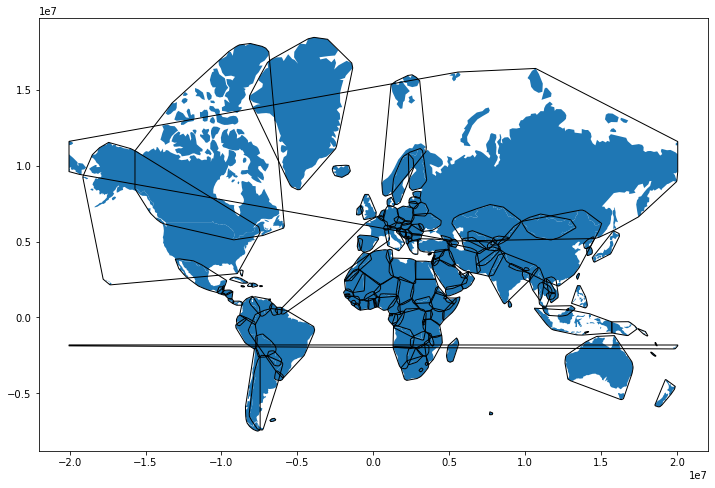

In [22]:
ax = world.plot(figsize=(12, 12))
world.convex_hull.plot(ax=ax, facecolor='none', edgecolor='black')

## What is Dask

From the docs:

> Dask provides advanced parallelism and distributed out-of-core computation with a dask.dataframe module designed to scale pandas. Since GeoPandas is an extension to the pandas DataFrame, the same way Dask scales pandas can also be applied to GeoPandas.

We will cover the high-level API of Dask. For more, see the [Dask tutorial](https://tutorial.dask.org).

Let's import `numpy` and `pandas` for a comparison and three high-level Dask modules - `bag`, `array`, and `dataframe`.

In [23]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

Before we explore those, let's introduce the dask `Client` as it will allow us to see how dask manages all its tasks.

Here we create a Client on top of a local (automatically created) cluster with 4 workers (the laptop we use has 4 performance cores).

In [24]:
from dask.distributed import Client

client = Client(n_workers=4)

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59020 instead
  warnings.warn(


In [25]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59020/status,
Dashboard: http://127.0.0.1:59020/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59021,Workers: 4
Dashboard: http://127.0.0.1:59020/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:59054,Total threads: 2
Dashboard: http://127.0.0.1:59057/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:59027,


We can open the Dask dashboard to watch what is happenning in real-time using the link above, in the Client details. But if you have a [JupyterLab extension for Dask](https://github.com/dask/dask-labextension), you can watch different components directly from the JupyterLab interface.

### dask.bag

With the Client and cluster in place, we can properly explore Dask. Let's start with a `dask.bag`, the simplest of the objects. You can imagine it as a distributed list.

In [26]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>

Now, note that when we try to call `b`, we don't see its contents. 

Let's check what happens with `sum`.

In [27]:
b.sum()

Again, we don't see the answer, but some abstract `Item` object instead. That is because Dask usually runs all the operations lazily and waits for a `compute` call before it does the actual computation.

Instead, it plans what it should do and create a task graph. That looks like this:

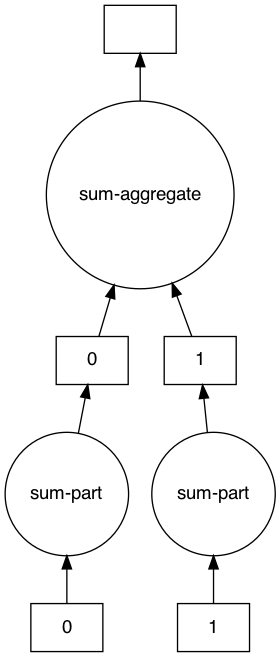

In [28]:
b.sum().visualize()

We can see individual partitions (rectangles), operations (circles), and movement of data between partitions.

When we call `compute`, this task graph is executed and Dask returns the expected value.

In [29]:
b.sum().compute()

24

### dask.array

Let's move onto an array. Where bag is partitioned along 1 dimension (the sequence is essentially cut into pieces), array is like a numpy array split along both dimension. In practice, each of the partitions is a numpy array and dask array combines them together. Each partition can be then processed separately. 

In [30]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

We see some dimensions, dtypes and sizes here but not the data. Beacause again, all is done lazily.

In [31]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

Even indexing requires `compute` to return values, otherwised it still give a dask array.

In [32]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

Simlarly for `mean`.

In [33]:
a.mean().compute()

49999.5

Since the mean is not super straightforward to parallelise (you can't just do mean in partitions and then mean of that), we can check how dask implements its logic.

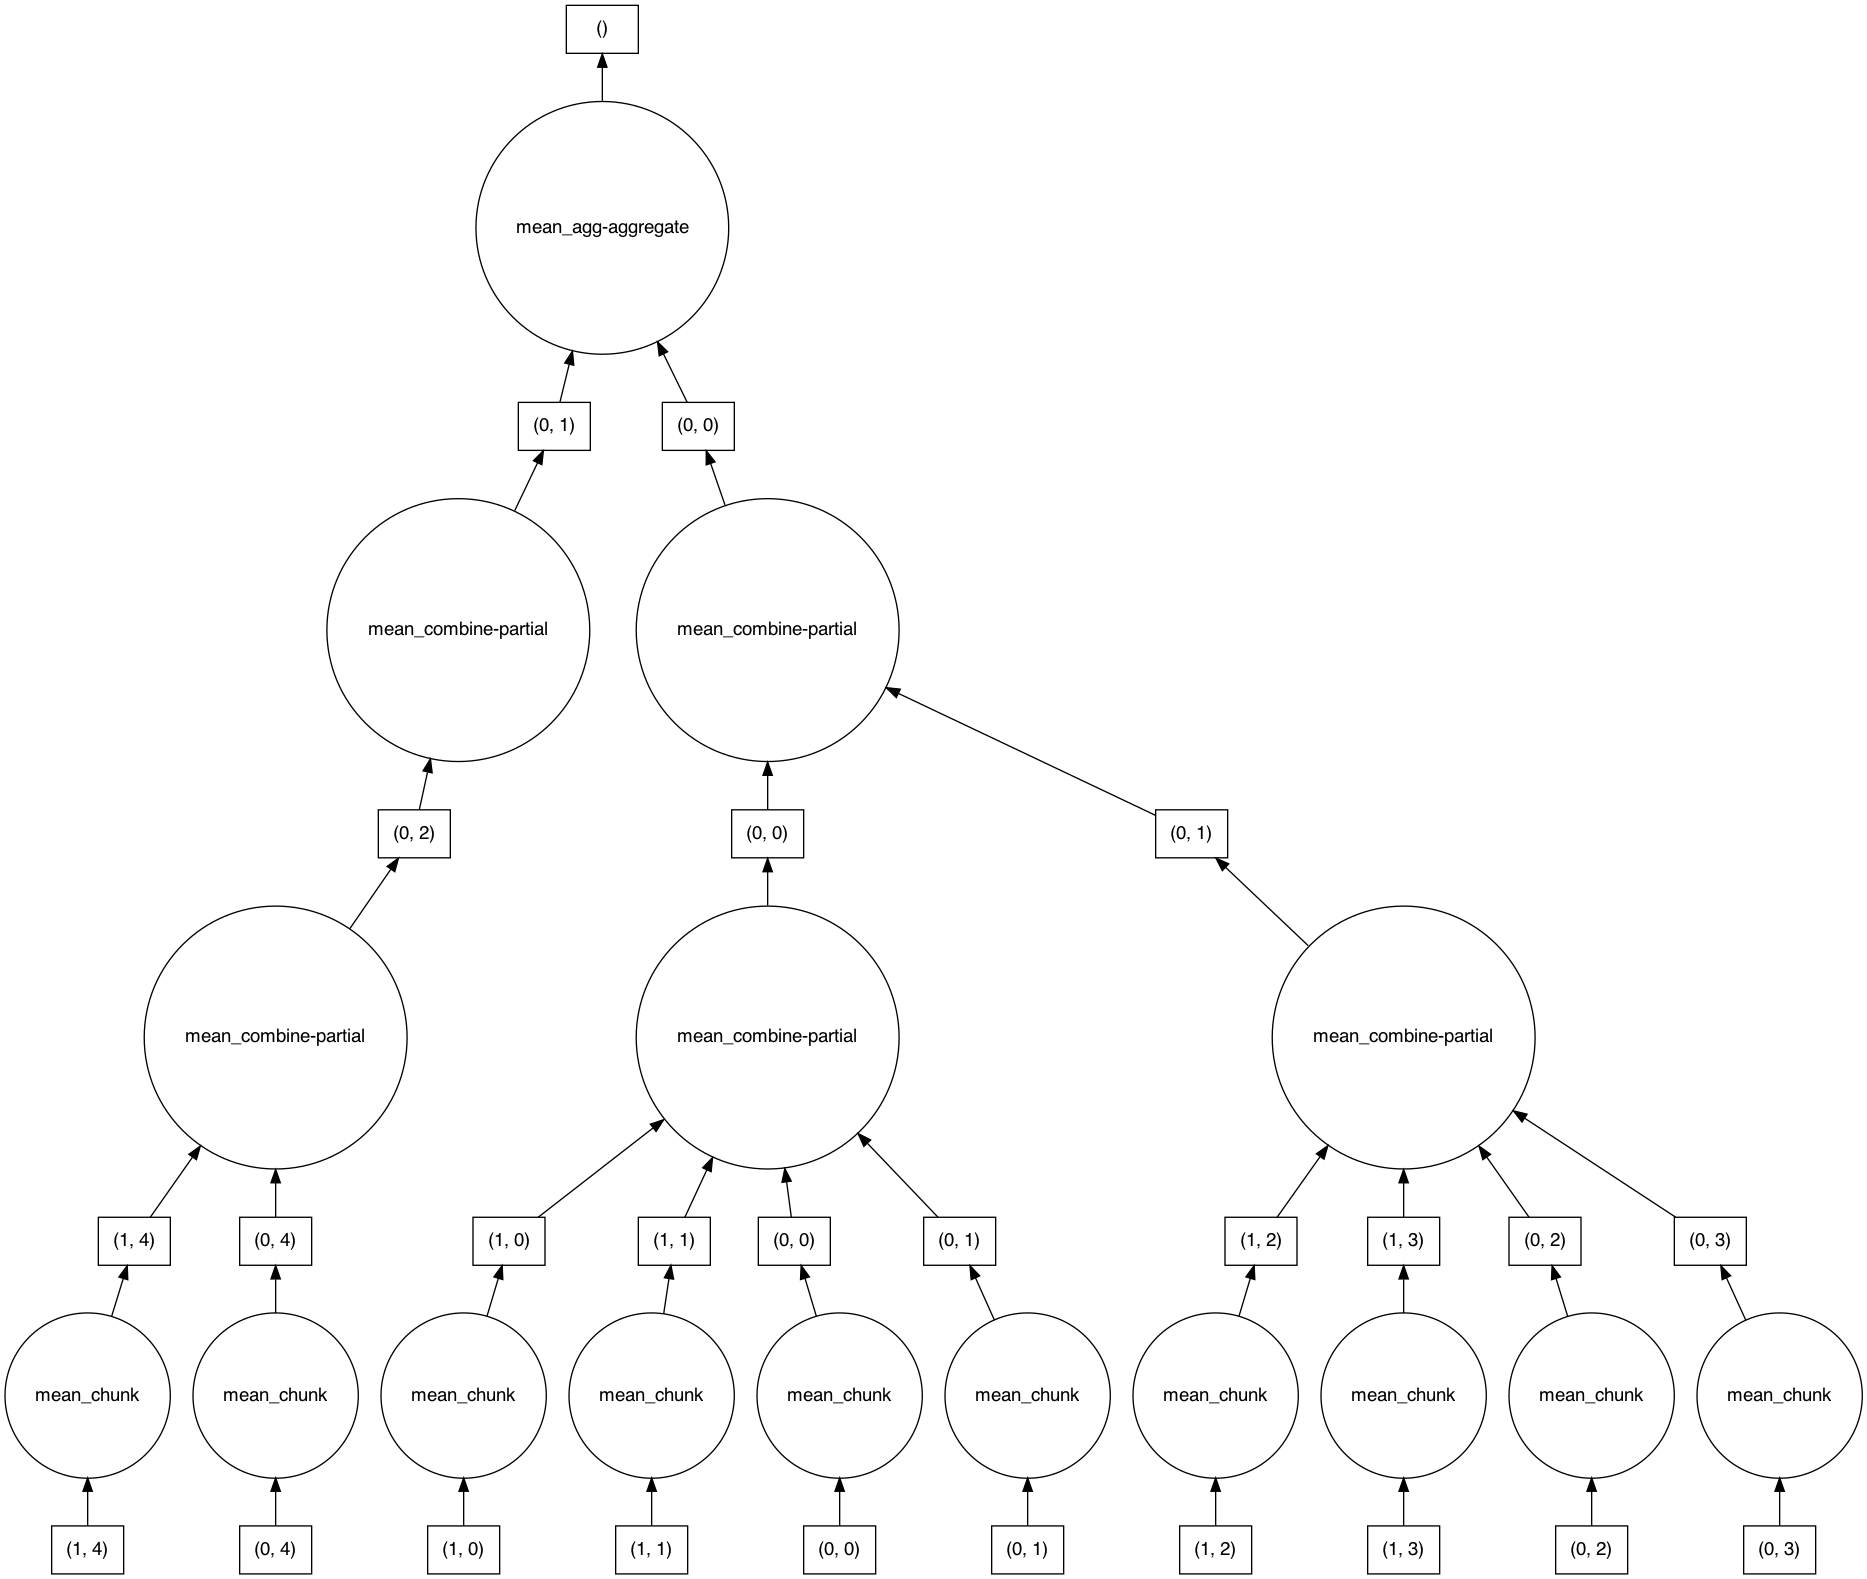

In [34]:
a.mean().visualize()

Quite complex, right? Let's compare it to the indexing we did before.

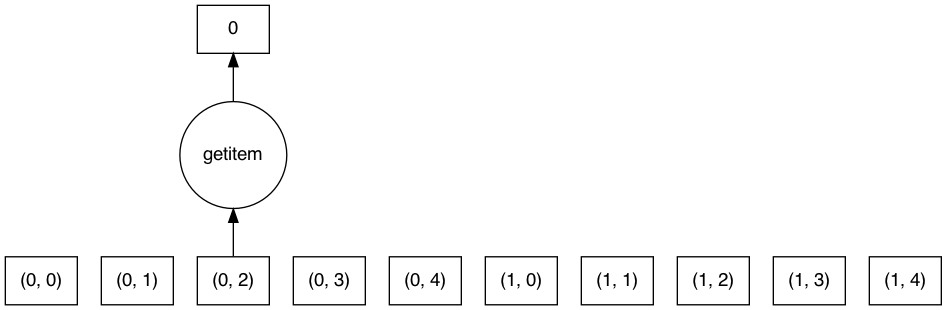

In [35]:
a[:50, 200].visualize()

You can see that dask efficiently accesses only that one partition it needs at this moment.

### dask.dataframe

Finally, we move to the parallelised DataFrame. It mirrors the logic of the array implementation, with a difference that individual partitions are pandas.DataFrames and partitioning happens along a single axis (rows).

Dask.dataframe tries to mirror the pandas API. The same approach as we will later see with dask-geopandas.

In [36]:
df = pd.read_csv("data/airports.csv")
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


In this specific case (`head()`), dask actually reads those 5 rows and shows them but that tends to be an exception, likely because it is a very cheap operation.

In [37]:
df = dd.read_csv("data/airports.csv")
df.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


If you try to show the whole DataFrame, you get a placeholder that tells you how many partitions you have, which columns and what are their dtypes.

In [38]:
df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
npartitions=1,,,,,,,
,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...


Since the `airports.csv` is a single file on disk, dask gives us a single partion. But when we have more of them, typically one per month or a country, we can read each as a partition.

In [39]:
df = dd.read_csv("data/airports_csv/*.csv")
df

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
npartitions=4,,,,,,,
,int64,object,object,object,float64,float64,float64
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


As before, all the computation is done lazily. Take a look at the computation of mean elevation.

In [40]:
elevation = df.elevation_ft.mean()
elevation

dd.Scalar<series-..., dtype=float64>

We get a dask Scalar object here but as before, we don't get the value until we call `compute()`.

In [41]:
elevation.compute()

1294.776494472499

You can probably notice the similarity of the graph with the one calculating mean over an array.

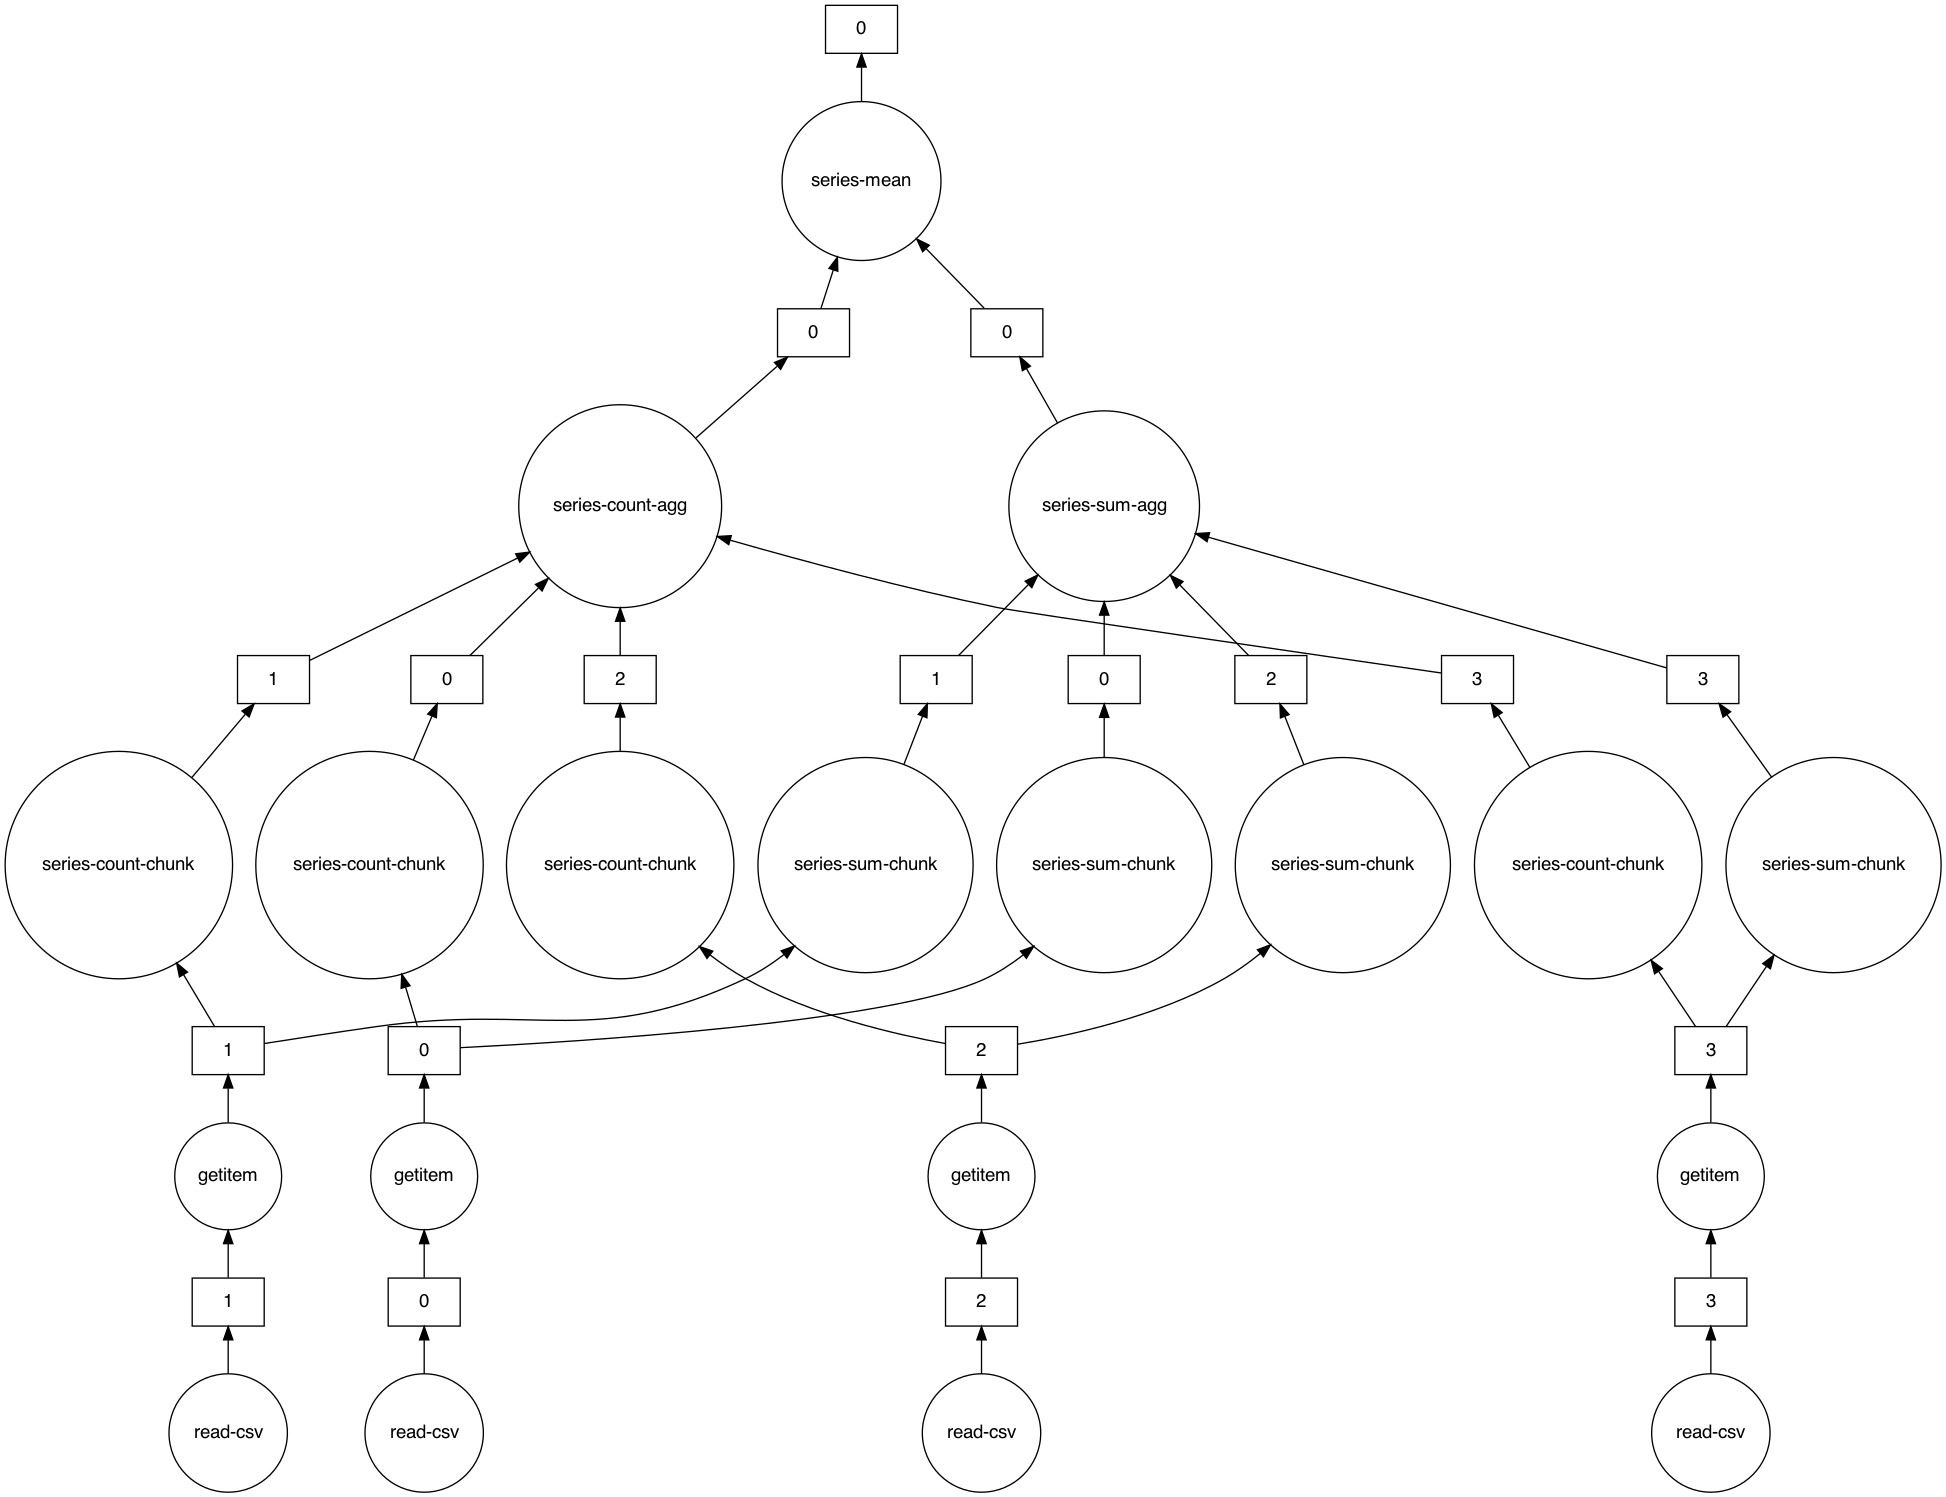

In [42]:
elevation.visualize()

We can also quickly compare it to a task graph for something easier, like a sum.

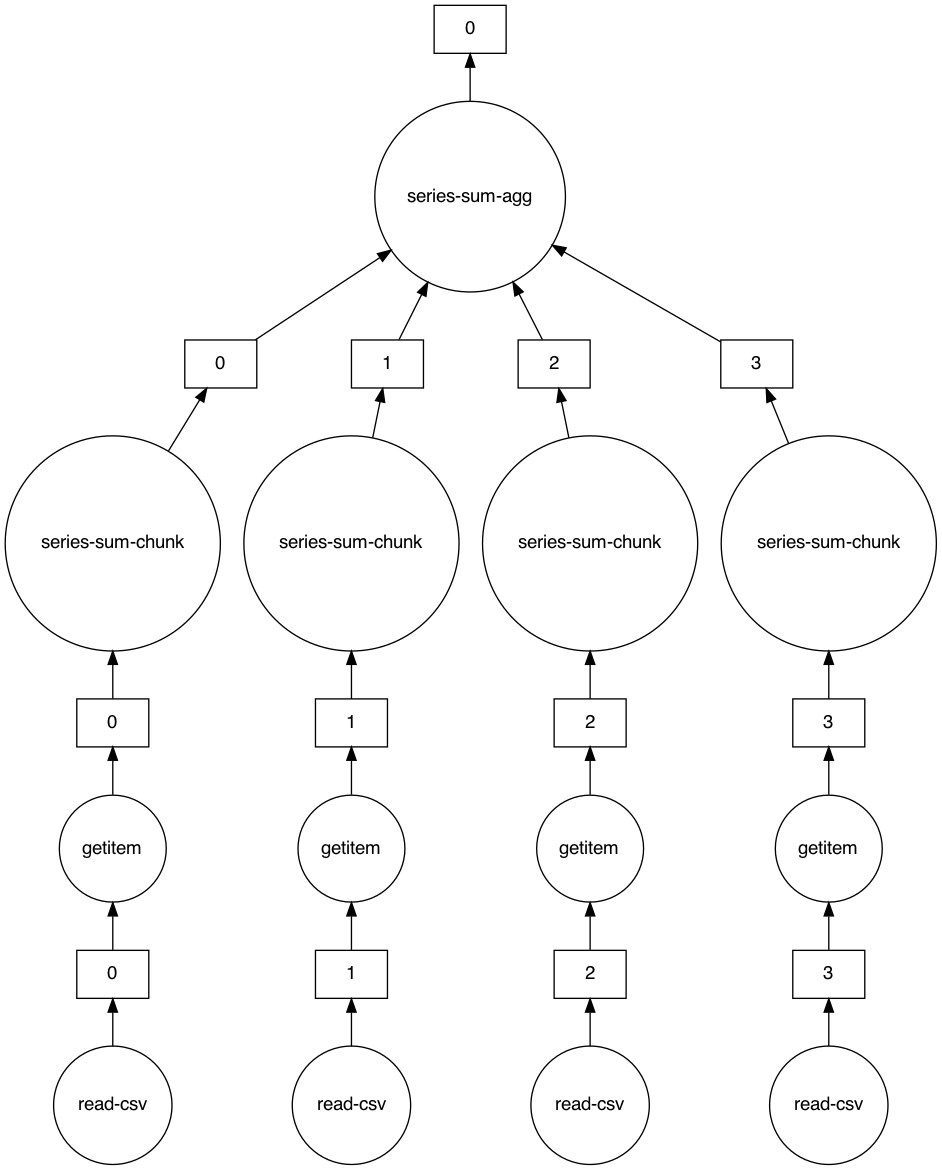

In [43]:
df.elevation_ft.sum().visualize()

Not that it makes much sense to compute a sum of elevations, but we can do that and if you're checking the dashboard, you'll notice very little communication as the task is easy to parallelise and we need to gather the results only in the final step.

In [44]:
df.elevation_ft.sum().compute()

75894619.0

## Dask-GeoPandas

Dask-GeoPandas follows exactly the same model as `dask.dataframe` adopted for scaling `pandas.DataFrame`. We have a single `dask_geopandas.GeoDataFrame`, composed of individual partitions where each is a `geopandas.GeoDataFrame`.

In [45]:
import dask_geopandas

## Create dask GeoDataFrame

We have a plenty of options how to build a `dask_geopandas.GeoDataFrame`. From in-memory `geopandas.GeoDataFrame`, reading the GIS file (using pyogrio under the hood), reading GeoParquet or Feather, or from dask.dataframe.

In [46]:
world_ddf = dask_geopandas.from_geopandas(world, npartitions=4)
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
0,int64,object,object,object,float64,geometry,geometry
44,...,...,...,...,...,...,...
88,...,...,...,...,...,...,...
132,...,...,...,...,...,...,...
176,...,...,...,...,...,...,...


In [47]:
world_ddf_file = dask_geopandas.read_file(path, npartitions=4)
world_ddf_file

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
npartitions=4,,,,,,
0,int64,object,object,object,float64,geometry
45,...,...,...,...,...,...
90,...,...,...,...,...,...
135,...,...,...,...,...,...
176,...,...,...,...,...,...


### Partitioned IO

Since we are working with individual partitions, it is useful to save the dataframe already partitioned. The ideal file format for that is a GeoParquet.

In [48]:
world_ddf.to_parquet("world/")

/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  return self.engine.write_partition(
/Users/martin/mambaforge/envs/geopython_tutorial/lib/python3.10/site-packages/dask/dataframe/io/parquet/core.py:154: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github

For more complex tasks, we recommend using Parquet IO as an intermediate step to avoid large task graphs.

In [49]:
world_ddf = dask_geopandas.read_parquet("world/")
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
,int64,object,object,object,float64,geometry,geometry
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


## Embarrassingly parallel computation

The first type of operations where you can benefit from parallelisation is so-called embarrassingly parallel computation. That is a computation where we treat individual partitions or individual rows indenpendently of the other, meaning there is no inter-worker communication and no data need to be sent elsewhere.

One example of that is a calculation of area.

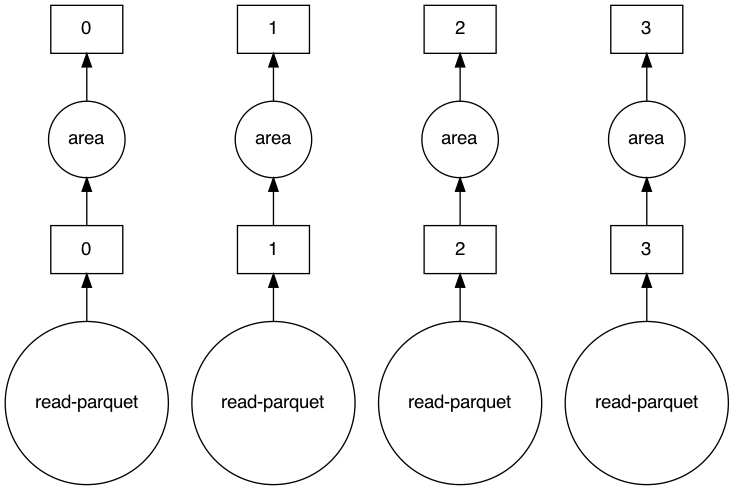

In [50]:
area = world_ddf.area
area.visualize()

Similar one, this time returing a `dask_geopandas.GeoSeries` instead of a `dask.dataframe.Series` would be a `convex_hull` method.

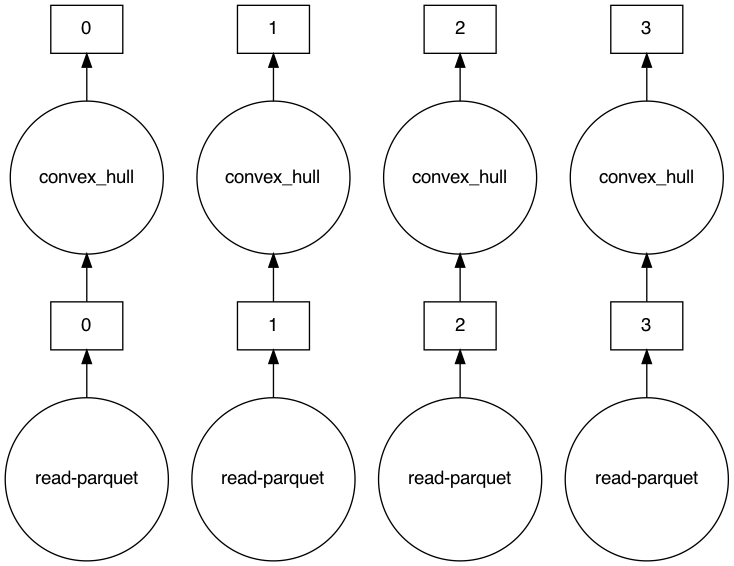

In [51]:
convex_hull = world_ddf.convex_hull
convex_hull.visualize()

Since both are creating a series, we can assing both as individual columns. Let's see how that changes the task graph.

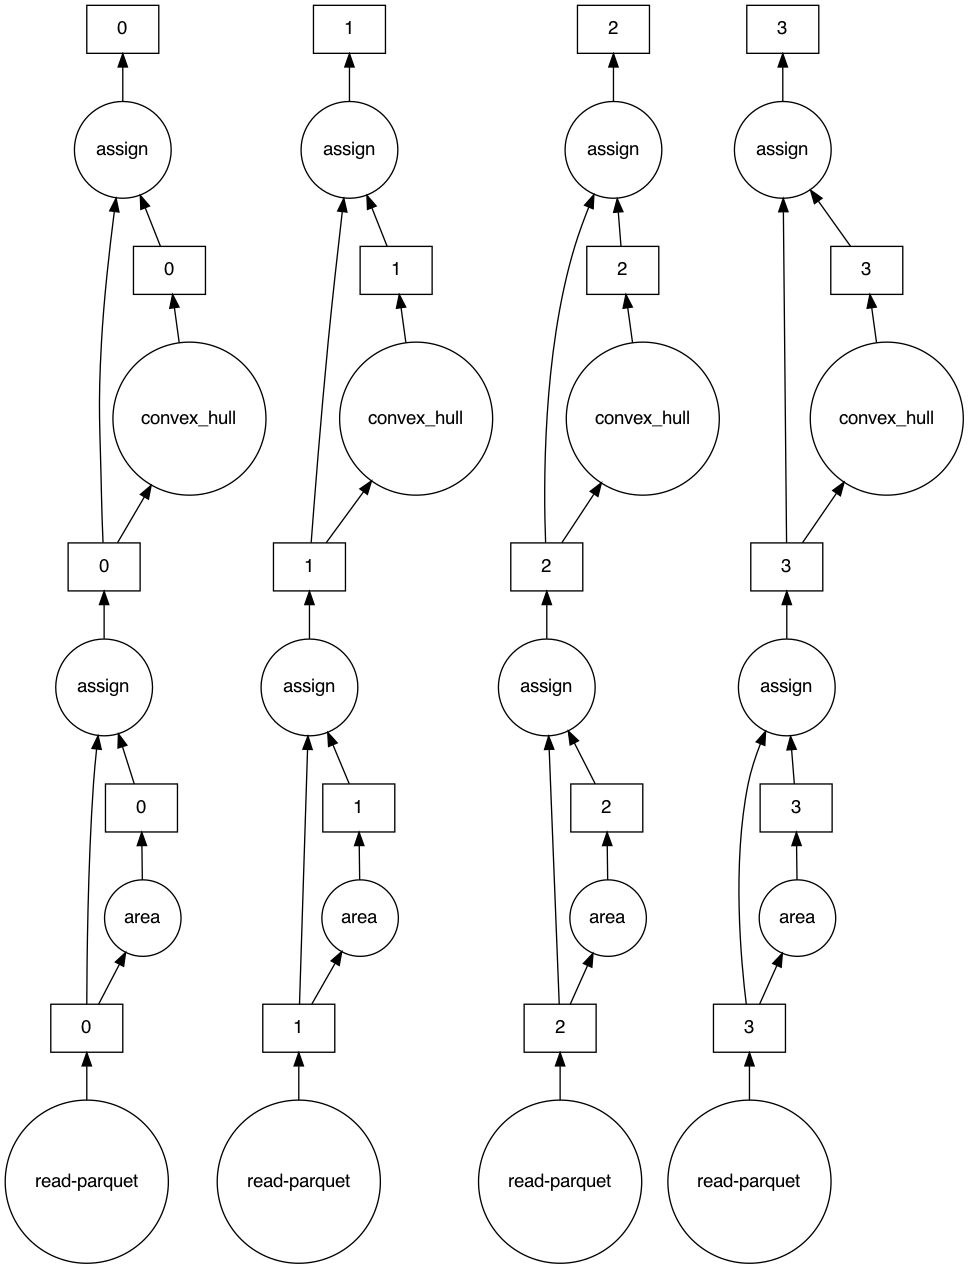

In [52]:
world_ddf['area'] = world_ddf.area
world_ddf['convex_hull'] = world_ddf.convex_hull
world_ddf.visualize()

Finally, we can call `compute()` and get all the results.

In [53]:
r = world_ddf.compute()

## Spatial join

If you have to deal with a large dataframes and need a spatial join, dask-geopandas can help. Let's try to illustrate the logic of spatial join on the partitioned data using the locations of airports from around the world.

In [54]:
airports = pd.read_csv("data/airports.csv")
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0


The data comes as a CSV, so we first need to create a GeoDataFrame.

In [55]:
airports = geopandas.GeoDataFrame(
    airports,
    geometry=geopandas.GeoSeries.from_xy(
        airports["longitude_deg"],
        airports["latitude_deg"],
        crs=4326,
    )
)

And from that, we can create a partitioned `dask_geopandas.GeoDataFrame`. Note that we could also read the CSV with dask.dataframe and create a GeoDataFrame from that using the `dask_geopandas.from_dask_dataframe` function and `dask_geopandas.points_from_xy` to create the geometry. But since it all comfortably fits in memory, we can pick whichever option we like.

In [56]:
airports_ddf = dask_geopandas.from_geopandas(
    airports,
    npartitions=12
)

We will join the point data of airports with the `naturalearth_lowres` dataset we have stored as an already partitioned parquet.

In [57]:
world_ddf = dask_geopandas.read_parquet("data/world/")
world_ddf

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull
npartitions=4,,,,,,,
,int64,object,object,object,float64,geometry,geometry
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


The API of the `sjoin` is exactly the same as you know it from geopandas. Just in this case, it currently only creates a task graph.

In [58]:
joined = airports_ddf.sjoin(world_ddf, predicate="within")

We started from 12 partitions of `airports_ddf` and 4 partitions of `world_ddf`. Since we haven't told Dask how are these partitions spatially distributed, it just plans to do the join of each partition from one dataframe to each partition form the other one. 12x4 = 48 partitions in the end. We can easily check that with the `npartitions` attribute.

In [59]:
joined.npartitions

48

The whole logic can also be represented by a task graph that illustates the inneficiency of such an approach.

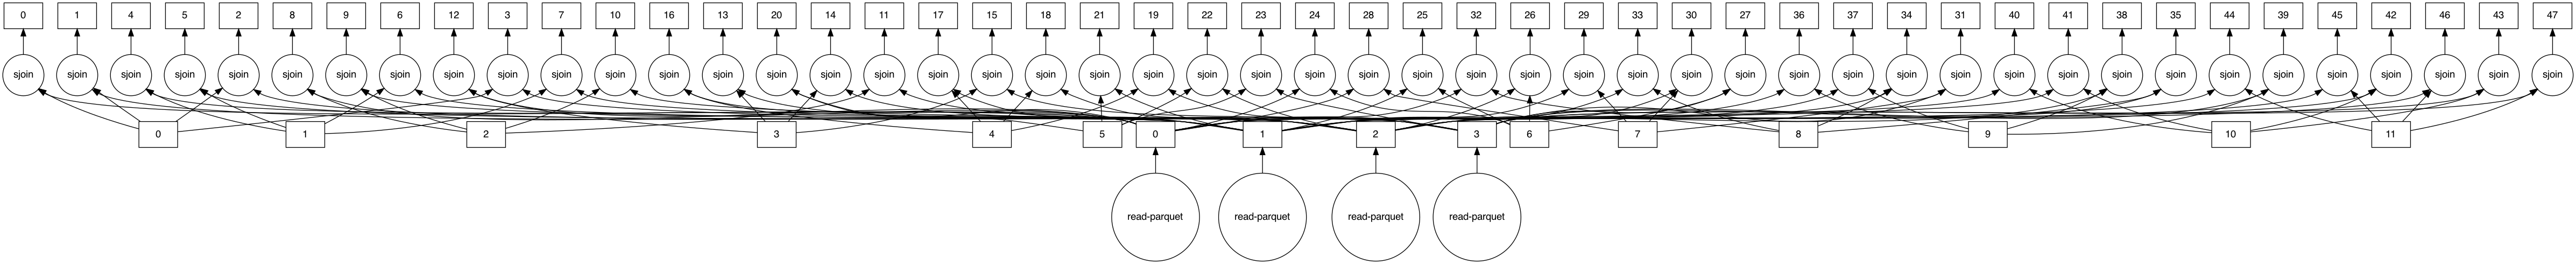

In [60]:
joined.visualize()

## Spatial partitioning

Luckily, dask-geopandas supports spatial partitioning. It means that it can calculate the spatial extent of each partition (as `partition.total_bounds`) and use it internally to do smarter decisions when creating the task graph. 

But first, we need to calculate these paritions. This operation is done eagerly and involves immediate reading of all geometries.

In [61]:
airports_ddf.calculate_spatial_partitions()

The resulting `spatial_partitions` attribute is a `geopandas.GeoSeries`.

In [62]:
airports_ddf.spatial_partitions

0     POLYGON ((169.85200 11.22200, -155.97835 19.83...
1     POLYGON ((-1.00000 -89.98944, -41.03330 -77.65...
2     POLYGON ((106.84825 -78.46614, -67.75550 -54.6...
3     POLYGON ((-25.51644 -75.56741, -71.56667 -74.8...
4     POLYGON ((-36.50950 -54.28240, -155.57840 19.1...
5     POLYGON ((139.27850 -24.33880, -157.19466 1.76...
6     POLYGON ((146.39617 -41.23519, -70.64390 -38.0...
7     POLYGON ((0.00000 -90.00000, -176.20348 -44.29...
8     POLYGON ((-81.39478 -80.31420, -83.32083 -79.7...
9     POLYGON ((70.22033 -49.35033, -56.16673 -34.86...
10    POLYGON ((-155.67730 18.91630, -159.74431 21.9...
11    POLYGON ((111.52361 -66.69083, -171.43511 -14....
dtype: geometry

In [63]:
airports_ddf.spatial_partitions.explore()

As you can see from the plot above, our partitions are not very homogenous in terms of their spatial distribution. Each contains points from nearly whole world. And that does not help with simplification of a task graph.

### The goal

We need our partitions to be spatially coherent to minimise the amount of inter-worker communication. So we have to find a way of reshuffling the data in between workers.

### Hilbert curve

One way of doing so is to follow the Hilbert space-filling curve, which is a 2-dimensional curve like the one below along which we can map our geometries (usually points). The distance along the Hilbert curve then represents a spatial proximity. Two points with a similar Hilbert distance are therefore ensured to be close in space.

![Hilbert](fig/Hilbert-curve_rounded-gradient-animated.gif)

(Animation by Tim Sauder, https://en.wikipedia.org/wiki/Hilbert_curve#/media/File:Hilbert-curve_rounded-gradient-animated.gif)

`dask-geopandas` (as of 0.1.0) implements Hilbert curve and two other methods based on a similar concept of space-filling (Morton curve and Geohash). You can either compute them directly or let `dask-geopandas` use them under the hood in a `spatial_shuffle` method that computes the distance along the curve and uses it to reshuffle the dataframe into spatially homogenous chunks. (Note that geometries are abstracted to the midpoint of their bounding box for the purpose of measuring the distance along the curve.)

In [64]:
hilbert_distance = airports_ddf.hilbert_distance()
hilbert_distance

Dask Series Structure:
npartitions=12
0        uint32
6031        ...
          ...  
66341       ...
72362       ...
Name: hilbert_distance, dtype: uint32
Dask Name: hilbert_distance, 24 tasks

In [65]:
hilbert_distance.compute()

0        1626125973
1        1254176125
2        1388750304
3        1970081721
4        1251544672
            ...    
72358    2477592609
72359    3541124831
72360    1249251466
72361    1460340716
72362    3025967453
Name: hilbert_distance, Length: 72363, dtype: uint32

`spatial_shuffle` uses by default `hilbert_distance` and partitions the dataframe based on this Series.

In [66]:
airports_ddf = airports_ddf.spatial_shuffle()

We can now check how the new partitions look like in space.

In [67]:
airports_ddf.spatial_partitions.explore()

When we are reading parquet file, its metadata already contain the information on the extent of each partition and we therefore don't have to calculate them by reading all the geometries. We can quickly check that.

In [68]:
world_ddf.spatial_partitions is not None

True

The world dataset has known partitions but is not spatially shuffled.

In [69]:
world_ddf.spatial_partitions.explore()

Even without doing that, we can already see that the resulting number of partitions is now 32, instead of 48 as some of the joins that would result in an empty dataframe are simply filtered out.

In [70]:
joined = airports_ddf.sjoin(world_ddf, predicate="within")

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_3560/1671005557.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(world_ddf, predicate="within")


In [71]:
joined.npartitions

34

In [72]:
%%time
joined.compute()

CPU times: user 330 ms, sys: 72.6 ms, total: 403 ms
Wall time: 681 ms


,id,ident,type,name_left,latitude_deg,longitude_deg,elevation_ft,geometry,index_right,pop_est,continent,name_right,iso_a3,gdp_md_est,convex_hull
hilbert_distance,,,,,,,,,,,,,,,
801122366,41113,SE16,small_airport,Loja Airport,-3.881424,-79.234749,7684.0,POINT (-79.23475 -3.88142),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
801144915,6083,SETM,small_airport,Camilo Ponce Enriquez Airport,-3.995890,-79.371902,4056.0,POINT (-79.37190 -3.99589),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
801352465,41595,EC-0001,small_airport,Carabon Airport,-3.628550,-80.187798,126.0,POINT (-80.18780 -3.62855),44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-8817092.447 -552738.227, -8954789.4..."
1880303520,2066,DAOE,small_airport,Bou Sfer Airport,35.735401,-0.805389,187.0,POINT (-0.80539 35.73540),82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((351561.777 2161690.786, -966742.962 ..."
1880352370,2071,DAOO,medium_airport,Oran International Airport Ahmed Ben Bella,35.623901,-0.621183,295.0,POINT (-0.62118 35.62390),82,40969443,Africa,Algeria,DZA,609400.0,"POLYGON ((351561.777 2161690.786, -966742.962 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278400869,342012,VU-0002,closed,Luganville Airfield,-15.515500,167.131900,484.0,POINT (167.13190 -15.51550),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."
3278411657,342011,VU-0001,closed,Turtle Bay Airfield,-15.377557,167.179473,58.0,POINT (167.17947 -15.37756),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."
3278684342,32056,NVSP,small_airport,Norsup Airport,-16.079700,167.401001,23.0,POINT (167.40100 -16.07970),89,282814,Oceania,Vanuatu,VUT,723.0,"POLYGON ((18647704.661 -1874062.146, 18567329...."


### What about a larger problem?

Dropping down from 48 to 32 partitions doesn't sound like a big deal. But you usually want to use dask-geopandas to tackle a bit larger problems. To simulate one, We can load a GADM dataset containd detailed administrative boundaries of the whole world (around 2GB GPKG) and join our airport data to that.

In [73]:
gadm_ddf = dask_geopandas.read_file('data/gadm404.gpkg', npartitions=64)
joined = airports_ddf.sjoin(gadm_ddf, predicate="within")
joined.npartitions

768

Without any spatial sorting of the GADM dataset, we have to do 12*64 joins.

But we can load the same dataset that has been spatially sorted.

In [57]:
gadm_sorted = dask_geopandas.read_parquet("data/gadm_spatial/")
joined = airports_ddf.sjoin(gadm_sorted, predicate="within")
joined.npartitions

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_3101/1806312542.py:2: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  joined = airports_ddf.sjoin(gadm_sorted, predicate="within")


151

The resulting number of partitions is 151, filtering out more than 80% of spatial joins that no longer need to be done.

## Aggregations with dissolve

In [58]:
world_ddf = dask_geopandas.read_parquet("data/world/")  # TODO get better world with more polygons
continents = world_ddf.dissolve('continent', split_out=6)
continents

,pop_est,name,iso_a3,gdp_md_est,convex_hull,geometry
npartitions=6,,,,,,
,int64,object,object,float64,geometry,geometry
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


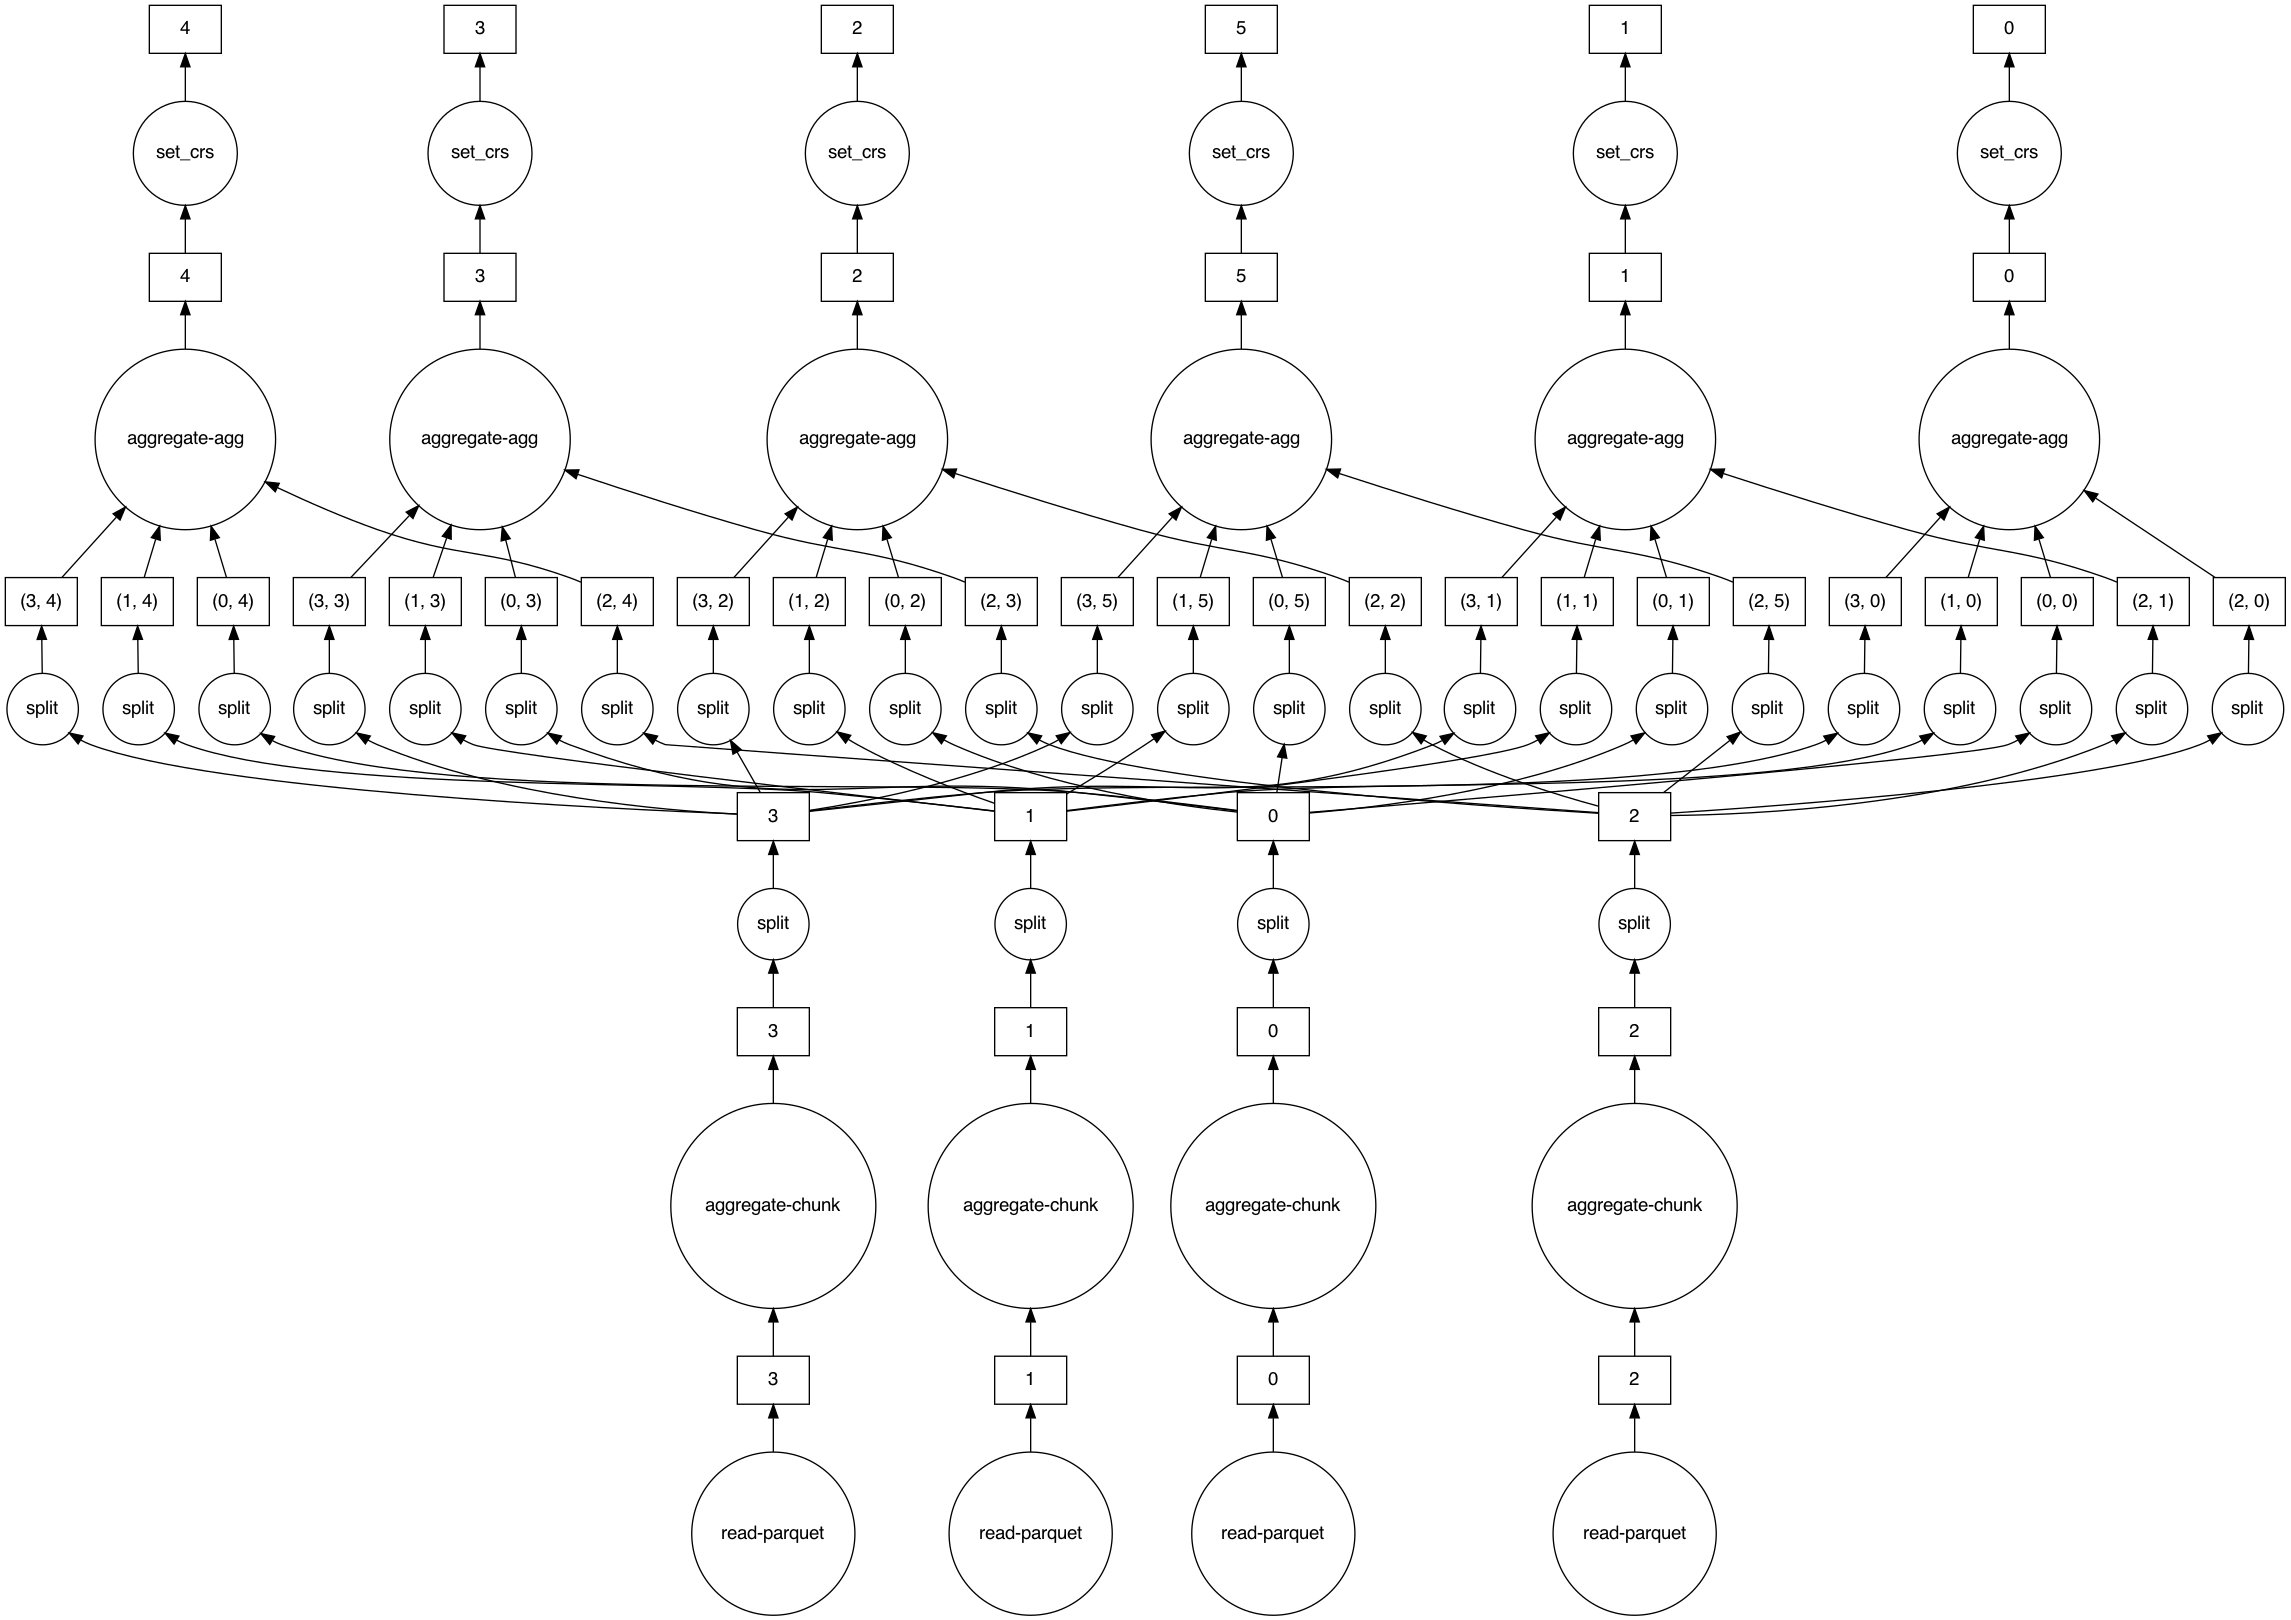

In [59]:
continents.visualize()

## Custom functions

In [60]:
from esda.shape import shape_index

In [61]:
world['shape_idx'] = shape_index(world)

In [62]:
world.explore('shape_idx')

In [63]:
world_ddf = dask_geopandas.read_parquet("world/")
shape_idx = world_ddf.map_partitions(shape_index)

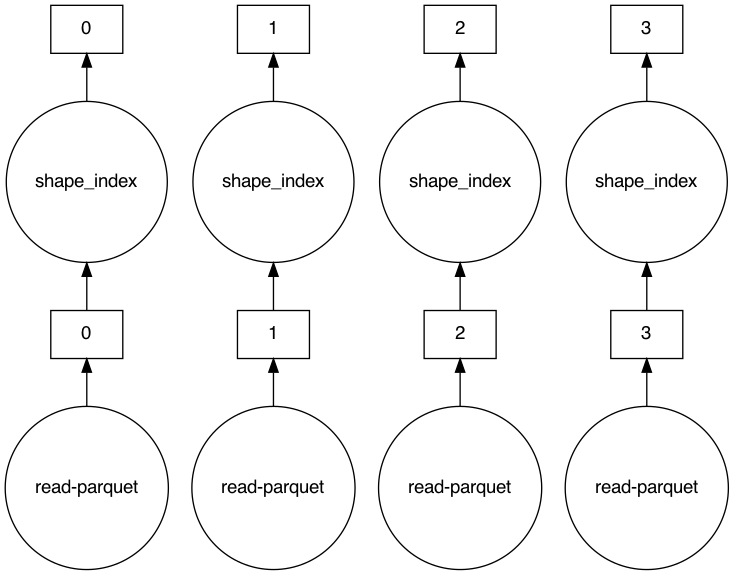

In [64]:
shape_idx.visualize()

In [65]:
r = shape_idx.compute()

### Custom function

In [66]:
def my_fn(gdf):
    """get a sum of area covered by polygons in a gdf
    
    Parameters
    ----------
    gdf : GeoDataFrame
    
    Returns
    -------
    float
    
    """
    area = gdf.geometry.area
    return sum(area)

In [67]:
world_ddf.map_partitions(my_fn).compute()

0    2.404711e+14
1    1.883620e+13
2    2.622637e+13
3    4.235641e+13
dtype: float64

In [68]:
def get_hull_area(gdf):
    """Get area of each convex hull and return pandas.Series
    
    Parameters
    ----------
    gdf : GeoDataFrame
    
    Returns
    -------
    pandas.Series
    """
    
    hulls = gdf.convex_hull
    return hulls.area

In [69]:
world_ddf['hull_area'] = world_ddf.map_partitions(get_hull_area)

In [70]:
world_ddf.compute()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,convex_hull,hull_area
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((20037508.343 -1812498.413, 200...","POLYGON ((19807373.107 -2071284.965, -20037508...",6.432272e+12
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((3774143.866 -105758.362, 3792946.708...","POLYGON ((4064728.977 -1313965.660, 3847200.38...",1.059699e+12
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-964649.018 3205725.605, -964597.245...","POLYGON ((-1899491.585 2391849.029, -1894705.4...",3.139454e+11
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-9205018.632 5112435.324, -13805051....",9.127826e+13
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...","POLYGON ((-17331127.807 2145071.126, -17358788...",7.099766e+13
...,...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((2096126.508 5765757.958, 2096127.988...","POLYGON ((2401900.131 5197783.944, 2255063.490...",1.891208e+11
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((2234260.104 5249565.284, 2204305.520...","POLYGON ((2156455.368 5142654.741, 2133155.290...",2.998349e+10
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((2292095.761 5139344.949, 2284604.344...","POLYGON ((2306240.400 5138104.706, 2292095.761...",2.435674e+10
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-6866186.192 1204901.071, -6802177.4...","POLYGON ((-6876204.946 1118889.975, -6896242.4...",8.808172e+09


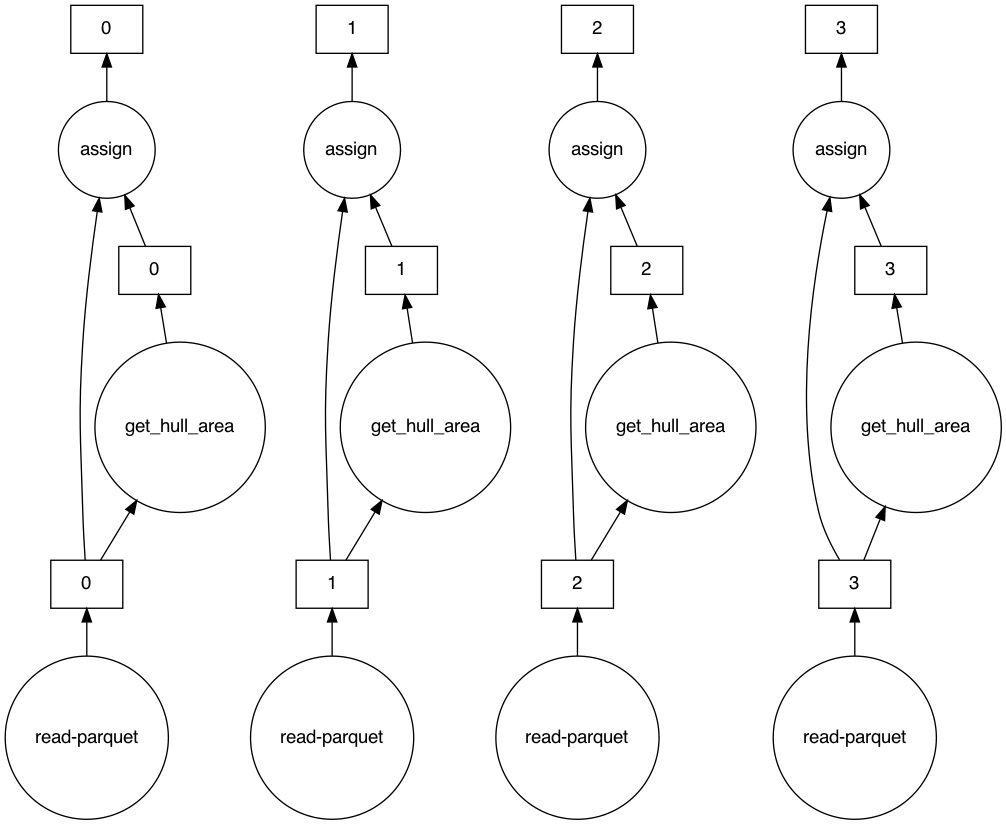

In [71]:
world_ddf.visualize()

### Speficying `meta`

In [72]:
world_ddf = dask_geopandas.read_parquet("data/world/")

In [73]:
shuffled = world_ddf.shuffle(
    "continent", npartitions=4, ignore_index=True
)

In [74]:
meta = world_ddf._meta.dissolve(by="continent", as_index=False)
meta

,continent,geometry,pop_est,name,iso_a3,gdp_md_est,convex_hull


In [75]:
meta.dtypes

continent        object
geometry       geometry
pop_est           int64
name             object
iso_a3           object
gdp_md_est      float64
convex_hull    geometry
dtype: object

In [76]:
dissolved = shuffled.map_partitions(
    geopandas.GeoDataFrame.dissolve, by="continent", as_index=False, meta=meta
)

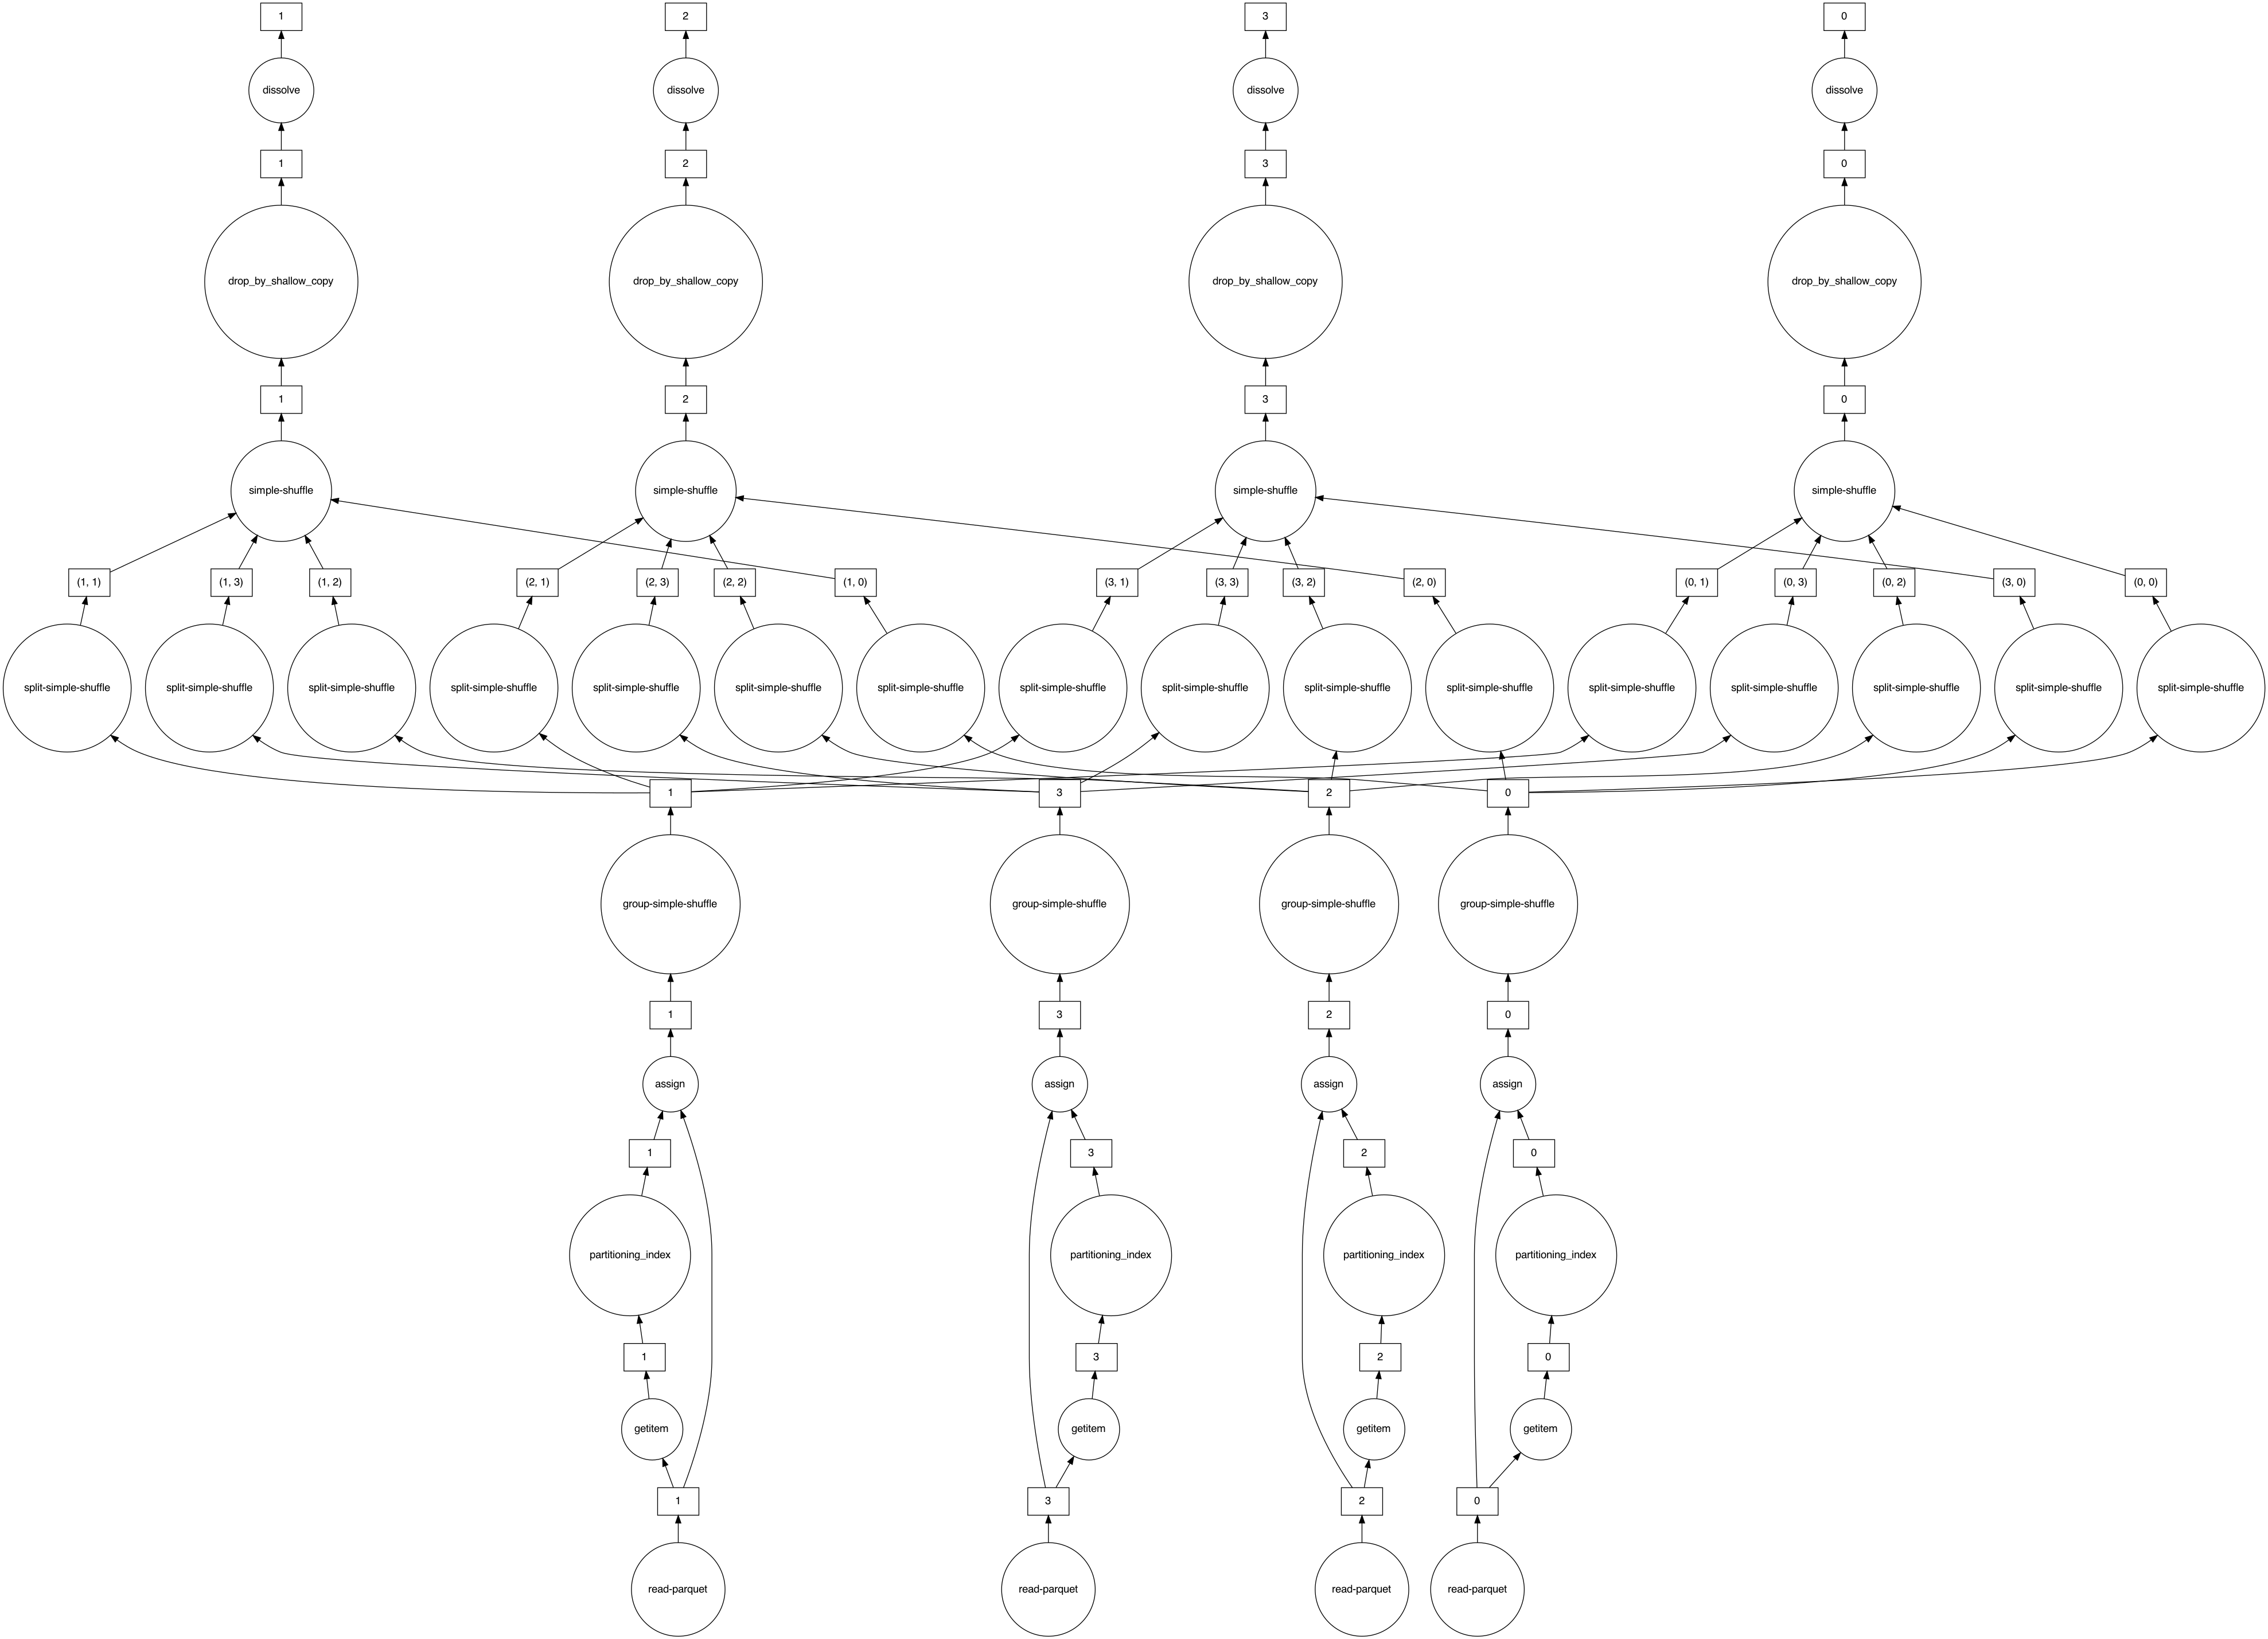

In [77]:
dissolved.visualize()

In [78]:
dissolved.compute()

,continent,geometry,pop_est,name,iso_a3,gdp_md_est,convex_hull
0,Africa,"MULTIPOLYGON (((-11.43878 6.78592, -11.70819 6...",53950935,Tanzania,TZA,150600.0,"POLYGON ((4064728.977 -1313965.660, 3847200.38..."
0,Asia,"MULTIPOLYGON (((48.67923 14.00320, 48.23895 13...",18556698,Kazakhstan,KAZ,460700.0,"POLYGON ((7598656.850 4962661.474, 6173250.313..."
1,Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",140,Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((7652658.395 -6407400.602, 7649875.40..."
2,South America,"MULTIPOLYGON (((-68.63999 -55.58002, -69.23210...",44293293,Argentina,ARG,879400.0,"POLYGON ((-7397180.163 -7410537.977, -7640229...."
0,Oceania,"MULTIPOLYGON (((147.91405 -43.21152, 147.56456...",920938,Fiji,FJI,8374.0,"POLYGON ((19807373.107 -2071284.965, -20037508..."
0,Europe,"MULTIPOLYGON (((-53.55484 2.33490, -53.77852 2...",142257519,Russia,RUS,3745000.0,"POLYGON ((5322815.560 5034701.226, -19357551.0..."
1,North America,"MULTIPOLYGON (((-155.22217 19.23972, -155.5421...",35623680,Canada,CAN,1674000.0,"POLYGON ((-9205018.632 5112435.324, -13805051...."


Finally, we can shut down the Dask client.

In [79]:
client.shutdown()

## Limits and caveats
- topology and cross-partition operations
- limited plotting support

## Exercises